In [1]:
import pandas as pd
import numpy as np
data=pd.read_csv('./input/train.csv',nrows=500)
#data.tail(10)

In [2]:
import tensorflow
np.random.seed(0)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.initializers import glorot_uniform
np.random.seed(1)
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r',encoding="utf8") as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [4]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('glove.6B.50d.txt')

In [5]:
Y=data['Label'].to_numpy()
X=data['Text'].to_numpy()
#X

In [6]:
import nltk
nltk.download('stopwords')
from nltk.tokenize import ToktokTokenizer
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
# custom: removing words from list
stopword_list.remove('not')
# function to remove stopwords
def remove_stopwords(text):
    # convert sentence into token of words
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    # check in lowercase 
    t = [token for token in tokens if token.lower() not in stopword_list]
    text = ' '.join(t)    
    return text
for i in range(len(X)):
    X[i]=remove_stopwords(X[i].lower())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\badar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
import re
def remove_special_characters(text):
    # define the pattern to keep
    pat = r'[#]'
    t=re.sub(pat,',',text)
    pat = r'[^a-zA-z0-9.,!?/:;\"\'\s]' 
    return re.sub(pat, '', t)
for i in range(len(X)):
    X[i]=remove_special_characters(X[i])

In [8]:
 X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, stratify=Y)

In [9]:
no_of_true_examples=np.count_nonzero(Y == 1)
#no_of_true_examples
no_of_true_in_test=np.count_nonzero(Y_test==1)
no_of_true_in_test

6

In [10]:
def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()` (described in Figure 4). 
    
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    
    m = X.shape[0]                                   # number of training examples
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices =np.zeros((m,max_len))
    
    for i in range(m):                               # loop over training examples
        
        # Convert the ith training sentence in lower case and split is into words. You should get a list of words.
        sentence_words = X[i].lower().split()
        
        # Initialize j to 0
        j = 0
        
        # Loop over the words of sentence_words

        for w in sentence_words:
            # if w exists in the word_to_index dictionary
            if w in word_to_index:
                # Set the (i,j)th entry of X_indices to the index of the correct word.
                X_indices[i, j] = word_to_index[w]
                # Increment j to j + 1
                j =  j+1
                if(j>=maxLen):
                    return X_indices
            
    
    return X_indices

In [11]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_size = len(word_to_index) + 1              # adding 1 to fit Keras embedding (requirement)
    any_word = list(word_to_vec_map.keys())[0]
    emb_dim = word_to_vec_map[any_word].shape[0]    # define dimensionality of your GloVe word vectors (= 50)
      
    ### START CODE HERE ###
    # Step 1
    # Initialize the embedding matrix as a numpy array of zeros.
    # See instructions above to choose the correct shape.
    emb_matrix = np.zeros((vocab_size,emb_dim))
    
    # Step 2
    # Set each row "idx" of the embedding matrix to be 
    # the word vector representation of the idx'th word of the vocabulary
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]

    # Step 3
    # Define Keras embedding layer with the correct input and output sizes
    # Make it non-trainable.
    embedding_layer = tensorflow.keras.layers.Embedding(vocab_size,emb_dim,trainable=False)
    ### END CODE HERE ###

    # Step 4 (already done for you; please do not modify)
    # Build the embedding layer, it is required before setting the weights of the embedding layer. 
    embedding_layer.build((None,)) # Do not modify the "None".  This line of code is complete as-is.
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [12]:
def n_model(input_shape, word_to_vec_map, word_to_index):
    """
    Function creating the  model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    # Define sentence_indices as the input of the graph.
    # It should be of shape input_shape and dtype 'int32' (as it contains indices, which are integers).
    sentence_indices = tensorflow.keras.Input(shape=input_shape,dtype='int32')
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagate sentence_indices through your embedding layer
    # (See additional hints in the instructions).
    embeddings = embedding_layer(sentence_indices)   
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # The returned output should be a batch of sequences.
    X = tensorflow.keras.layers.LSTM(units=128,return_sequences=True)(embeddings)
    # Add dropout with a probability of 0.5
    X = tensorflow.keras.layers.Dropout(0.5)(X) 
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # The returned output should be a single hidden state, not a batch of sequences.
    X = tensorflow.keras.layers.LSTM(units=128)(X)
    # Add dropout with a probability of 0.5
    X = tensorflow.keras.layers.Dropout(0.5)(X)
    # Propagate X through a Dense layer with 2 units
    X = tensorflow.keras.layers.Dense(units=1,activation='relu')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model =tensorflow.keras.Model(inputs=sentence_indices,outputs=X)
    
    
    return model

In [13]:
maxLen=300

In [ ]:
model = n_model((maxLen,), word_to_vec_map, word_to_index)
model.summary()

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [ ]:
model.compile(loss='BinaryCrossentropy', optimizer='adam', metrics=['accuracy'])

In [14]:
X_train_indices = sentences_to_indices(X_train, word_to_index,maxLen)

In [ ]:
history=model.fit(X_train_indices, Y_train, epochs = 20, batch_size = 16, shuffle=True)

In [ ]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len = maxLen)
loss, acc= model.evaluate(X_test_indices, Y_test)
print()
print("Test accuracy = ", acc)

In [ ]:
#MISLABELLED EXAMPLES
pred =(model.predict(X_test_indices)>0.4).astype(int)
for i in range(len(X_test)):
    if(pred[i] != Y_test[i]):
        print('Expected label:'+str(Y_test[i]) + ' prediction: '+str(X_test[i]) + '/n')
        

In [ ]:
pred

In [ ]:
from sklearn.metrics import precision_score
precision_score(Y_test ,pred, average='micro')

In [ ]:
from sklearn.metrics import plot_confusion_matrix
IC = type('IdentityClassifier', (), {"predict": lambda i : i, "_estimator_type": "classifier"})
plot_confusion_matrix(IC,pred, Y_test, normalize='true', values_format='.2%')  
plt.show()

In [ ]:
from sklearn.metrics import recall_score
recall_score(Y_test,pred, average='micro')

In [16]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(random_state=0)

In [17]:
clf = clf.fit(X_train_indices,Y_train)

[Text(200.88000000000002, 181.2, 'X[1] <= 250620.5\ngini = 0.225\nsamples = 450\nvalue = [392, 58]'),
 Text(133.92000000000002, 108.72, 'X[60] <= 226.0\ngini = 0.222\nsamples = 449\nvalue = [392, 57]'),
 Text(66.96000000000001, 36.23999999999998, 'gini = 0.224\nsamples = 444\nvalue = [387, 57]'),
 Text(200.88000000000002, 36.23999999999998, 'gini = 0.0\nsamples = 5\nvalue = [5, 0]'),
 Text(267.84000000000003, 108.72, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]')]

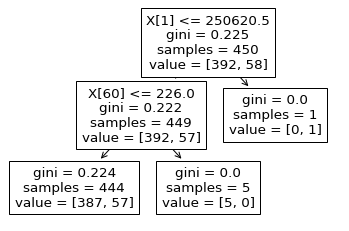

In [18]:
tree.plot_tree(clf) 

In [19]:
pred=clf.predict(X_test_indices)

In [20]:
pred

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 0, 1, 0, 1, 0], dtype=int64)

In [21]:
recall_score(Y_test,pred, average='micro')

NameError: name 'recall_score' is not defined

In [ ]:
precision_score(Y_test ,pred, average='micro')

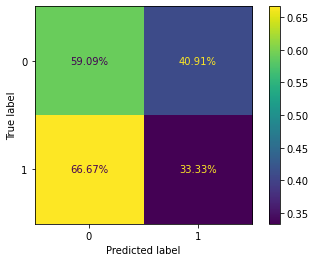

In [23]:
from sklearn.metrics import plot_confusion_matrix
IC = type('IdentityClassifier', (), {"predict": lambda i : i, "_estimator_type": "classifier"})
plot_confusion_matrix(IC,pred, Y_test, normalize='true', values_format='.2%')  
plt.show()

In [ ]:
for i in range(len(X_test)):
    if(pred[i] ==1):
        print('Expected label:'+str(Y_test[i]) + ' prediction: '+str(X_test[i]) + '\n')